In [1]:
from os import chdir, environ

chdir("..")

import flox
import lightning as L
import matplotlib.pyplot as plt

from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor
from torchvision.datasets import MNIST

from flox.aggregator import FedAvg
from flox.worker import SimpleWorkerLogic
from modules import BasicMnistModule, MnistModule

/opt/anaconda3/envs/FLoX/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/opt/anaconda3/envs/FLoX/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c106detail19maybe_wrap_dim_slowIxEET_S2_S2_b
  Referenced from: <6A7076EE-85BD-37A7-BC35-1D4867F2B3D3> /opt/anaconda3/envs/FLoX/lib/python3.10/site-packages/torchvision/image.so
  Expected in:     <F2FE5CF8-5B5B-3FAD-ADF8-C77D90F49FC9> /opt/anaconda3/envs/FLoX/lib/python3.10/site-packages/torch/lib/libc10.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [2]:
class MnistAggrLogic(FedAvg):
    def on_module_evaluate(self, module: L.LightningModule):
        root = environ["TORCH_DATASETS"]
        test_data = MNIST(root, download=False, train=False, transform=ToTensor())
        test_dataloader = DataLoader(test_data)
        trainer = L.Trainer()
        return trainer.test(module, test_dataloader)


class MnistWorkerLogic(SimpleWorkerLogic):
    def __init__(self, idx, indices):
        super().__init__(idx)
        self.name = "mnist"
        self.indices = indices

    def on_data_fetch(self):
        from torch.utils.data import Subset
        from torchvision.datasets import MNIST
        from torchvision.transforms import ToTensor
        from os import environ

        root = environ["TORCH_DATASETS"]
        data = MNIST(root, download=True, train=True, transform=ToTensor())
        data = Subset(data, indices=self.indices)
        return data

    def __len__(self) -> int:
        return len(self.indices)

In [3]:
workers = flox.create_workers(5, MnistWorkerLogic)
results = flox.federated_fit(
    global_module=MnistModule(),
    aggr=MnistAggrLogic(participation_frac=0.25),
    workers=workers,
    global_rounds=20,
    mode="local"  # TODO: Currently doesn't do anything.
)
results

federated_fit: 100%|██████████| 20/20 [00:15<00:00,  1.26it/s]


{'module': MnistModule(
   (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
   (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
   (dropout1): Dropout(p=0.25, inplace=False)
   (dropout2): Dropout(p=0.5, inplace=False)
   (fc1): Linear(in_features=9216, out_features=128, bias=True)
   (fc2): Linear(in_features=128, out_features=10, bias=True)
   (test_accuracy): MulticlassAccuracy()
 ),
 'train_results':                          time  round  worker_id  train_loss
 0  2023-08-01 14:05:47.311135      1          1    2.055280
 1  2023-08-01 14:05:48.002356      2          2    2.286931
 2  2023-08-01 14:05:48.801977      3          1    2.187804
 3  2023-08-01 14:05:49.219306      4          3    2.284532
 4  2023-08-01 14:05:49.611593      5          3    2.683346
 5  2023-08-01 14:05:50.629488      6          4    2.322960
 6  2023-08-01 14:05:51.034566      7          3    2.290424
 7  2023-08-01 14:05:51.699025      8          2    2.256611
 8  2023-08-01 14:05:52.3

In [4]:
train_df = results["train_results"]
print(train_df)

                         time  round  worker_id  train_loss
0  2023-08-01 14:05:47.311135      1          1    2.055280
1  2023-08-01 14:05:48.002356      2          2    2.286931
2  2023-08-01 14:05:48.801977      3          1    2.187804
3  2023-08-01 14:05:49.219306      4          3    2.284532
4  2023-08-01 14:05:49.611593      5          3    2.683346
5  2023-08-01 14:05:50.629488      6          4    2.322960
6  2023-08-01 14:05:51.034566      7          3    2.290424
7  2023-08-01 14:05:51.699025      8          2    2.256611
8  2023-08-01 14:05:52.390403      9          2    2.171245
9  2023-08-01 14:05:53.429873     10          4    2.272766
10 2023-08-01 14:05:54.468743     11          4    2.269560
11 2023-08-01 14:05:55.154271     12          2    2.400100
12 2023-08-01 14:05:56.181863     13          0    2.243373
13 2023-08-01 14:05:56.863177     14          2    2.248274
14 2023-08-01 14:05:57.913630     15          4    2.301400
15 2023-08-01 14:05:58.717923     16    

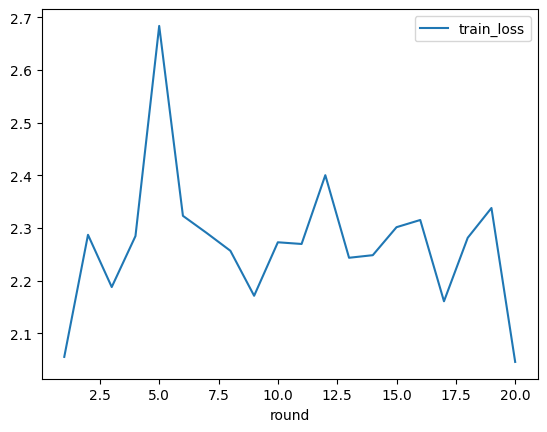

In [5]:
train_df.plot(kind="line", x="round", y="train_loss")
plt.show()